In [6]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

#### Loading in the processed data and mapping the target column to binary output

In [8]:
os.chdir('/Users/aashish/Desktop/repos/What-Are-The-Odds/processed_data')
os.getcwd()

'/Users/aashish/Desktop/repos/What-Are-The-Odds/processed_data'

In [9]:
engin = pd.read_csv("nonsparsetheta.csv")
engin = engin.drop('Unnamed: 0', axis=1)
engin['y'] = np.where(engin['target'] == engin['player1_name'],
                              'player1',
                              'player2')
m = {"player1": 0, "player2": 1}
engin['maptarget'] = engin['y'].map(m)
engin = engin.drop('y', axis=1)

In [11]:
engin.columns
enginx = engin[[

    "player1_ht", 
    "player2_ht", 
    "player1_rank", 
    "player2_rank", 
    "player1_h2h", 
    "player2_h2h",
    "surface", 
    "tourney_level",
    "player_1_recent_form",
    "player_2_recent_form",
    "player_1_theta_form",
    "player_2_theta_form",
    'player1_surface_win_pct', 
    'player2_surface_win_pct',
    'player1_level_win_pct', 
    'player2_level_win_pct',]]
enginy = engin['maptarget']

In [12]:
le = LabelEncoder()
enginx['surface'] = le.fit_transform(enginx['surface'])
enginx['tourney_level'] = le.fit_transform(enginx['tourney_level'])

/var/folders/bn/5c_f564903b2g4rg6w0jy4km0000gn/T/ipykernel_51761/2338595702.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  enginx['surface'] = le.fit_transform(enginx['surface'])
/var/folders/bn/5c_f564903b2g4rg6w0jy4km0000gn/T/ipykernel_51761/2338595702.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  enginx['tourney_level'] = le.fit_transform(enginx['tourney_level'])


In [13]:
engintrainx, engintestx, engintrainy, engintesty = train_test_split(enginx, enginy, test_size=0.25, random_state=5323)

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate
import xgboost

#### Pipline for cross-validation and model metrics

In [16]:
def cv(model, X, y, cv=100):
    scoring = ['accuracy', 'precision', 'recall', 'f1']
    results = cross_validate(estimator=model,
                             X = X,
                             y = y,
                             cv=cv,
                             scoring=scoring,
                             return_train_score=True,
                             return_estimator=True)
    return {
            "Mean Training Accuracy": results['train_accuracy'].mean()*100,
            "Mean Training Precision": results['train_precision'].mean(),
            "Mean Training Recall": results['train_recall'].mean(),
            "Mean Training F1 Score": results['train_f1'].mean(),
            "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
            "Mean Validation Precision": results['test_precision'].mean(),
            "Mean Validation Recall": results['test_recall'].mean(),
            "Mean Validation F1 Score": results['test_f1'].mean(),
            "model": results
            }

In [17]:
logit = LogisticRegression(solver='liblinear')
logit_result = cv(logit, X=engintrainx, y = engintrainy, cv=5)

In [18]:
logit_result

{'Mean Training Accuracy': 69.95364697708439,
 'Mean Training Precision': 0.6953316358761665,
 'Mean Training Recall': 0.6793490506848484,
 'Mean Training F1 Score': 0.6872450632382098,
 'Mean Validation Accuracy': 69.7847258428159,
 'Mean Validation Precision': 0.694049549067196,
 'Mean Validation Recall': 0.677087786969049,
 'Mean Validation F1 Score': 0.6853528853779152,
 'model': {'fit_time': array([0.09321594, 0.13702583, 0.10313702, 0.1093061 , 0.12332368]),
  'score_time': array([0.00672483, 0.0098393 , 0.00495815, 0.00645089, 0.01157522]),
  'estimator': [LogisticRegression(solver='liblinear'),
   LogisticRegression(solver='liblinear'),
   LogisticRegression(solver='liblinear'),
   LogisticRegression(solver='liblinear'),
   LogisticRegression(solver='liblinear')],
  'test_accuracy': array([0.69154229, 0.68866195, 0.71563236, 0.69277108, 0.7006286 ]),
  'train_accuracy': array([0.7017808 , 0.70171533, 0.69438261, 0.7006874 , 0.6991162 ]),
  'test_precision': array([0.68729282, 0

In [19]:
rf = RandomForestClassifier()

#randomized grid search cv to find the best range 
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [False]

randomgrid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = randomgrid, n_iter = 2, cv = 3, verbose=2, random_state=5323)
rf_random.fit(engintrainx, engintrainy)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=  19.3s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=  19.5s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=  19.2s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=  31.6s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=  32.4s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=  32.2s


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=2,
                   param_distributions={'bootstrap': [False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=5323, verbose=2)

In [20]:
rf_random.best_params_

{'n_estimators': 600,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 30,
 'bootstrap': False}

In [21]:
rft = RandomForestClassifier(
    n_estimators=600,
    min_samples_split=4,
    min_samples_leaf=4,
    max_features='sqrt',
    max_depth=20,
    bootstrap=False)

rft.fit(engintrainx, engintrainy)

RandomForestClassifier(bootstrap=False, max_depth=20, min_samples_leaf=4,
                       min_samples_split=4, n_estimators=600)

In [22]:
from sklearn.metrics import accuracy_score
preds = rft.predict(engintestx)
accuracy_score(engintesty, preds)

0.6997643362136685

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 [Text(0, 0, 'player1_ht'),
  Text(1, 0, 'player2_ht'),
  Text(2, 0, 'player1_rank'),
  Text(3, 0, 'player2_rank'),
  Text(4, 0, 'player1_h2h'),
  Text(5, 0, 'player2_h2h'),
  Text(6, 0, 'surface'),
  Text(7, 0, 'tourney_level'),
  Text(8, 0, 'player_1_recent_form'),
  Text(9, 0, 'player_2_recent_form'),
  Text(10, 0, 'player_1_theta_form'),
  Text(11, 0, 'player_2_theta_form'),
  Text(12, 0, 'player1_surface_win_pct'),
  Text(13, 0, 'player2_surface_win_pct'),
  Text(14, 0, 'player1_level_win_pct'),
  Text(15, 0, 'player2_level_win_pct')])

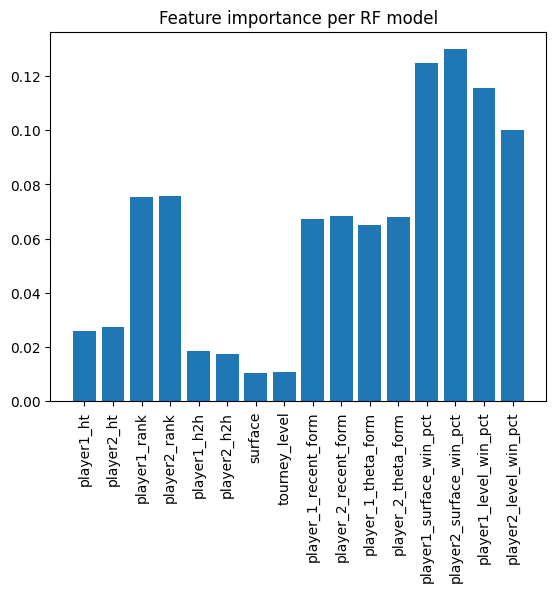

In [23]:
import matplotlib.pyplot as plt
plt.bar(engintrainx.columns, rft.feature_importances_)
plt.title("Feature importance per RF model")
plt.xticks(rotation=90)

In [24]:
#xgboost doesn't play nice with the cv method I made 
#xgresults = cv(model=xgb, X = engintrainx, y = engintrainy, cv=10)
xgb = xgboost.XGBClassifier()
xgb.fit(engintrainx, engintrainy)
xgp = xgb.predict(engintestx)
accuracy_score(engintesty, xgp)

0.6878240377062058

#### Exploring the confidence metric using logistic regression. Is it needed or does rank cover it well enough?

In [25]:
enginxwithout = engin[[

    "player1_ht", 
    "player2_ht", 
    "player1_rank", 
    "player2_rank", 
    "player1_h2h", 
    "player2_h2h",
    "surface", 
    "tourney_level",
    'player1_surface_win_pct', 
    'player2_surface_win_pct',
    'player1_level_win_pct', 
    'player2_level_win_pct',]]

enginxwith = engin[[
 
    "player1_ht", 
    "player2_ht", 
    "player1_rank", 
    "player2_rank", 
    "player1_h2h", 
    "player2_h2h",
    "surface", 
    "tourney_level",
    "player_1_theta_form",
    "player_2_theta_form",
    'player1_surface_win_pct', 
    'player2_surface_win_pct',
    'player1_level_win_pct', 
    'player2_level_win_pct',]]

enginy = engin['maptarget']
enginxwith['surface'] = le.fit_transform(enginx['surface'])
enginxwith['tourney_level'] = le.fit_transform(enginx['tourney_level'])
enginxwithout['surface'] = le.fit_transform(enginx['surface'])
enginxwithout['tourney_level'] = le.fit_transform(enginx['tourney_level'])

/var/folders/bn/5c_f564903b2g4rg6w0jy4km0000gn/T/ipykernel_51761/1114835898.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  enginxwith['surface'] = le.fit_transform(enginx['surface'])
/var/folders/bn/5c_f564903b2g4rg6w0jy4km0000gn/T/ipykernel_51761/1114835898.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  enginxwith['tourney_level'] = le.fit_transform(enginx['tourney_level'])
/var/folders/bn/5c_f564903b2g4rg6w0jy4km0000gn/T/ipykernel_51761/1114835898.py:36: SettingWithCopyWarning: 
A value is try

In [26]:
engintrainxwith, engintestxwith, engintrainy, engintesty = train_test_split(enginxwith, enginy, test_size=0.25, random_state=5323)
engintrainxwithout, engintestxwithout, engintrainy, engintesty = train_test_split(enginxwithout, enginy, test_size=0.25, random_state=5323)

In [27]:
from statsmodels.api import Logit

logitwith = Logit(engintrainy.astype(int),engintrainxwith).fit()
logitwithout = Logit(engintrainy.astype(int),engintrainxwithout).fit()

Optimization terminated successfully.
         Current function value: 0.566349
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.567229
         Iterations 6


In [28]:
predswith = logitwith.predict(engintestxwith)
predswith = list(map(round,predswith))
print(accuracy_score(engintesty, predswith))
predswithout = logitwithout.predict(engintestxwithout)
predswithout = list(map(round,predswithout))
print(accuracy_score(engintesty, predswithout))

0.6991358994501178
0.6958366064414768


In [29]:
print(logitwith.summary())

                           Logit Regression Results                           
Dep. Variable:              maptarget   No. Observations:                19093
Model:                          Logit   Df Residuals:                    19079
Method:                           MLE   Df Model:                           13
Date:                Wed, 19 Jul 2023   Pseudo R-squ.:                  0.1825
Time:                        16:26:11   Log-Likelihood:                -10813.
converged:                       True   LL-Null:                       -13227.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
player1_ht                 -0.0006      0.002     -0.352      0.725      -0.004       0.003
player2_ht                  0.0007      0.002      0.372      0.710      -0.003       0.004


In [30]:
print(logitwithout.summary())

                           Logit Regression Results                           
Dep. Variable:              maptarget   No. Observations:                19093
Model:                          Logit   Df Residuals:                    19081
Method:                           MLE   Df Model:                           11
Date:                Wed, 19 Jul 2023   Pseudo R-squ.:                  0.1812
Time:                        16:26:14   Log-Likelihood:                -10830.
converged:                       True   LL-Null:                       -13227.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
player1_ht                 -0.0008      0.002     -0.446      0.656      -0.004       0.003
player2_ht                  0.0012      0.002      0.670      0.503      -0.002       0.005
